<a href="https://colab.research.google.com/github/egorssed/Galaxy_modelling_VAE/blob/main/VAE_training_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/TP4b/'

import sys
import os
sys.path.append(Folder+'/Modules')

#Utility modules
import Variational_autoencoder as VAE
import VAE_analysis as Analysis
import Image_Fits_Stats
import Visual_analysis

VAE.image_size=64
VAE.batch_size = 32
VAE.latent_dim = 64
VAE.start_lr = 1e-6

Mounted at /content/drive


### Prepare the data

In [2]:
from sklearn.model_selection import train_test_split


#We normalize the data to [0,1]

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Radial_cut=0.05/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/Radial_cut=0.05/Labels_MAD_Filtered.csv',index_col=0)

#Leave the number of images multiple of the batch_size
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%VAE.batch_size)])
Number_of_batches=Size_of_dataset//VAE.batch_size
df=df.iloc[:Size_of_dataset]
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(VAE.normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

Label the images such that we can pass additional information to the reconstruction loss functions

In [3]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

In [4]:
#Data to estimate model's quality

COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

### Load model

In [8]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

#Weights of current model
Checkpoint_to_load=0
Checkpoint_name='Models/Pretrain_MAE_beta=1e-2_epoch_130/MSE_beta=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

#Pretrained weights
Pretrain_Checkpoint=130
Pretrain_Folder=Folder+'Models/MAE+Softplus/beta_vae=1e-2/'
models['vae'].load_weights(Pretrain_Folder+'epoch_{}/Model'.format(Pretrain_Checkpoint))

if Checkpoint_to_load==0:
  try:
    os.mkdir(Checkpoints_Folder)
  except OSError as error:
    print(error)
else:
  models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

### Callbacks

In [9]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

def on_epoch_end(epoch=0, logs=''):
  #global beta_vae
  #Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  #Every N epoch do the following
  if np.mod(epoch,1)==0:
        clear_output()
        
        imgs_decoded=models['vae'].predict(imgs, batch_size=VAE.batch_size)
        Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,\
                                        labels=labels_to_compare,grads=True)
        
        labels_test=x_test_labeled[:,-1,:,0]
        decoded_test= models['vae'].predict(x_test, batch_size=VAE.batch_size)

        gradients=Analysis.calculate_gradient(x_test,decoded_test,reconstruction_loss_function,labels_test)
        Max_gradients=np.max(gradients.reshape((len(gradients),4096)),axis=1)
        plt.hist(Max_gradients,bins=20)
        plt.title('Max gradients')
        plt.show()

        #Also take a look on how latent space variables are distributed
        Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

        mean_test = models['z_meaner'](x_test)
        logvar_test=models['z_log_varer'](x_test)
        DKL=Analysis.DKL_per_variable(mean_test,logvar_test)
        #print('Controlled Capacity',Epoch_Capacity)
        print('Latent space Capacity',DKL.sum())
        #print('Beta', beta_vae)

        fig,ax=plt.subplots(1,3,figsize=(10,5))
        maxima=K.eval(decoded_test).max(axis=(1,2,3))
        maxima_RAE=np.abs(maxima-1)
        ax[0].hist(maxima,bins=20)
        ax[0].set_title('Distribution of reconstructed maximum')

        reconstruction_loss=K.eval(K.mean(reconstruction_loss_function(x_test,decoded_test,labels_test),axis=[1,2]))
        reconstruction_loss=np.sort(reconstruction_loss)[:int(len(reconstruction_loss)*0.99)]
        ax[1].hist(reconstruction_loss,bins=40)
        ax[1].set_title('reconstruction loss')

        SSIM=tf.image.ssim(x_test.astype('double'), decoded_test.astype('double'),max_val=1,filter_size=8).numpy()
        ax[2].hist(SSIM,bins=20)
        ax[2].set_title('SSIM')
        plt.show()

        print('Max values RAE {:.3f} ± {:.3f}, median {:.3f}'.format(maxima_RAE.mean(),maxima_RAE.std(),np.median(maxima_RAE)))
        print('reconstruction loss values {:.6f} ± {:.6f}, median {:.6f}'.format(reconstruction_loss.mean(),reconstruction_loss.std(),np.median(reconstruction_loss)))
        print('SSIM values {:.3f} ± {:.3f}, median {:.3f}'.format(SSIM.mean(),SSIM.std(),np.median(SSIM)))
        
        if (epoch!=0):
          #Write loss logs
          file_object = open(Checkpoints_Folder+'logs.txt', 'a')
          file_object.write(str(logs))
          file_object.write('\n')
          file_object.close()

          #Write KL divergence of latent space 
          file_object = open(Checkpoints_Folder+'DKL.txt', 'a')
          file_object.write(str(DKL))
          file_object.write('\n')
          file_object.close()

          Analysis.learning_curve(Checkpoints_Folder+'logs.txt',0,100000)

          Analysis.DKL_learning_curve(Checkpoints_Folder+'DKL.txt')
          #Make a checkpoint of model weights and logs on Google drive
          if np.mod(epoch,10)==0:
            Model_folder=Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load+epoch)
            models['vae'].save_weights(Model_folder)



def on_epoch_begin(epoch=0, logs=''):
  global Capacity
  global beta_vae
  Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  Epoch_beta=beta_start+(epoch+Checkpoint_to_load)*beta_speed
  #Assign new value to the global variable Capacity
  Capacity=Epoch_Capacity
  beta_vae=Epoch_beta

        

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
capacity_control=LambdaCallback(on_epoch_begin=on_epoch_begin)
lr_red = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-10,verbose=1)

### Training

8
Maximal brightness 1.0


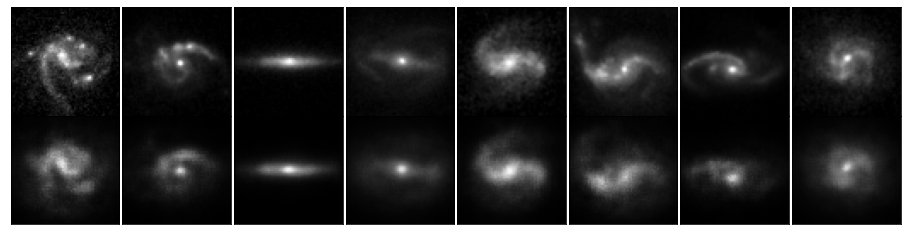

Maximal brightness 1.0


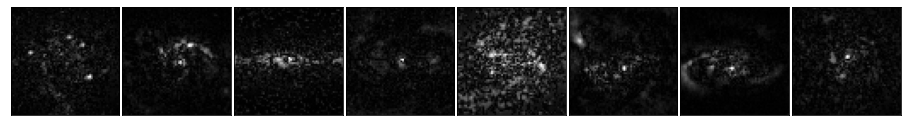

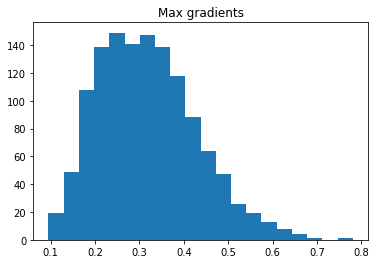

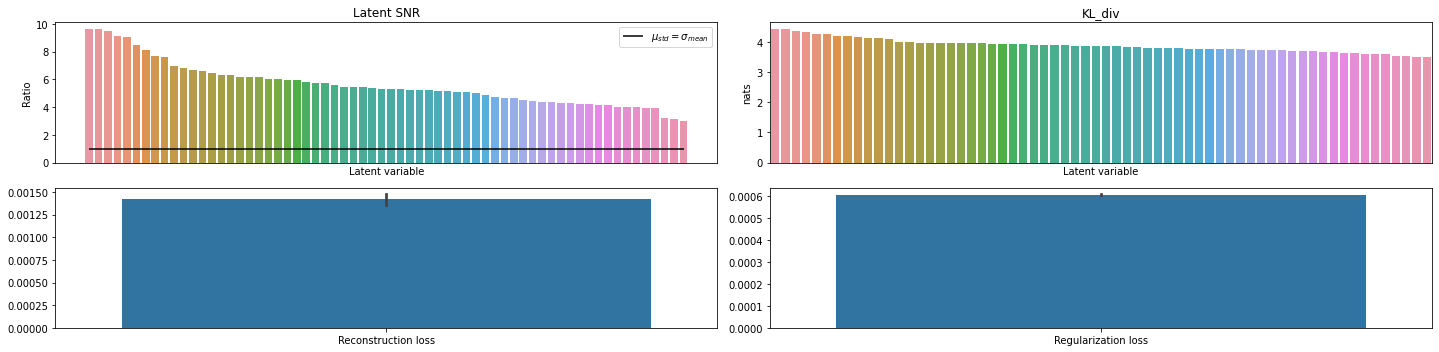

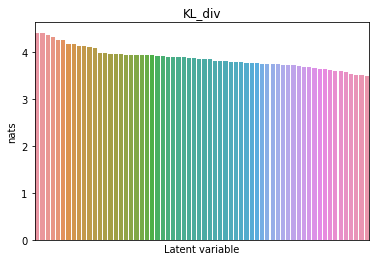

Latent space Capacity 248.18527


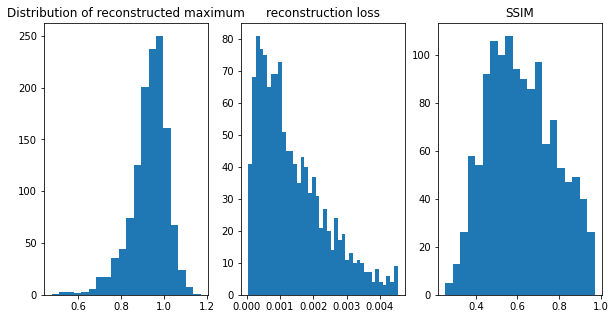

Max values RAE 0.081 ± 0.075, median 0.061
reconstruction loss values 0.001377 ± 0.000999, median 0.001098
SSIM values 0.620 ± 0.160, median 0.608


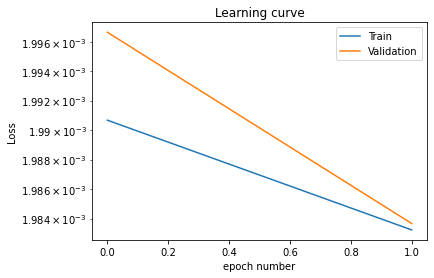

0 2 2


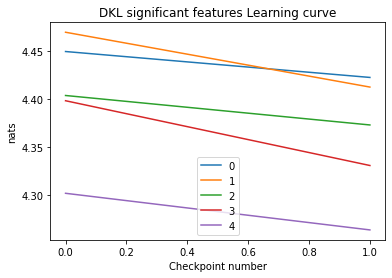

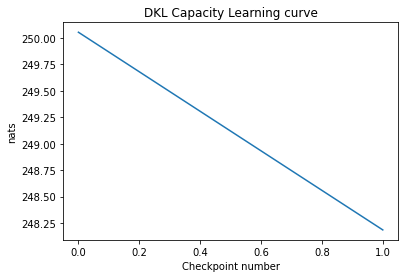

Epoch 4/900
310/716 [===========>..................] - ETA: 1:18 - loss: 0.0020

In [ ]:
_ = models['vae'].fit(x_train,x_train_labeled, shuffle=True, epochs=900,
        batch_size=VAE.batch_size,
        validation_data=(x_val,x_val_labeled),
        callbacks=[pltfig,lr_red],
        verbose=1)